# Train and deploy a neuronal network in the AWS cloud

In the following notebook is shown how to train and deploy a Keras Neuronal Network model. This Neuronal Network is going to serve as an inference engine endpoint at AWS Sagemaker. The model is going to be triggered from a Lambda function when new values from a field sensor arrives. The predictions can be then be used to send a notification.


As field soft sensor, a [RMG/941](https://www.ssv-embedded.de/produkte/rmg941.php) is used.

### Step 1:

Import general libraries and import files from S3. The files are stored in a compressed .tgz file. These files where uploaded to S3 with the PyDSlog app from the RMG/941 gateway.

The Bucket is the same as the defined when the files were uploaded to S3 from the soft sensor and the prefix is a timestamp that is used at the same time as folder name.

In [43]:
import json
import numpy as np
import pandas as pd
import boto3
import tarfile
import sagemaker

BUCKET = "ssv-ml-data-23-03" 
PREFIX = "1584963433941"

# download files from s3 to sagemaker
s3 = boto3.client('s3')
s3.download_file(BUCKET, PREFIX+".tgz", PREFIX+".tgz")

Since the files are loaded in a compressed .tgz file, they must be unpacked before the signals can be read.
The config.cfg file stores configurations parameters like frequency of the sensor and the length of the signals. These configurations are needed for the FFT transformation.

In [44]:
# extract tar files
tar = tarfile.open(PREFIX+".tgz")
tar.extractall()
tar.close()

# read config
with open(PREFIX+"/"+"config.cfg") as f:
    config = str(f.read())
    
config = json.loads(config)

sig      = bool(config["save_as_signal"])
channels = list(config["channels"])
freq     = int(config["frequency"])
N        = int(config["frame_size"])

X_FILES = ["x_"+n+"_.csv" for n in channels]


# read signals into numpy arrays
signals = []
for file in X_FILES:
    data_location = PREFIX+"/"+file
    s = np.array(pd.read_csv(data_location, header=None, index_col=None))
    signals.append(s)
signals = np.transpose(np.array(signals), (1, 0, 2))

# read labels into numpy arrays
Y_FILE = "y_.csv"
data_location = PREFIX+"/"+Y_FILE
labels = np.array(pd.read_csv(data_location, header=None, index_col=None))
labels = np.squeeze(labels)


# print shapes
print(labels.shape)
print(signals.shape)

(454,)
(454, 3, 400)


In [124]:
print(config)

{'add_tmp': 'ms', 'labeled': 'True', 'header': 'True', 'frame_size': '400', 'frequency': '400', 'source': 'MLS/160A', 'save_as_signal': 'True', 'channels': ['ACCX', 'ACCY', 'ACCZ']}


See how the data looks like. It is possible to see differences between the signals of differents classes?

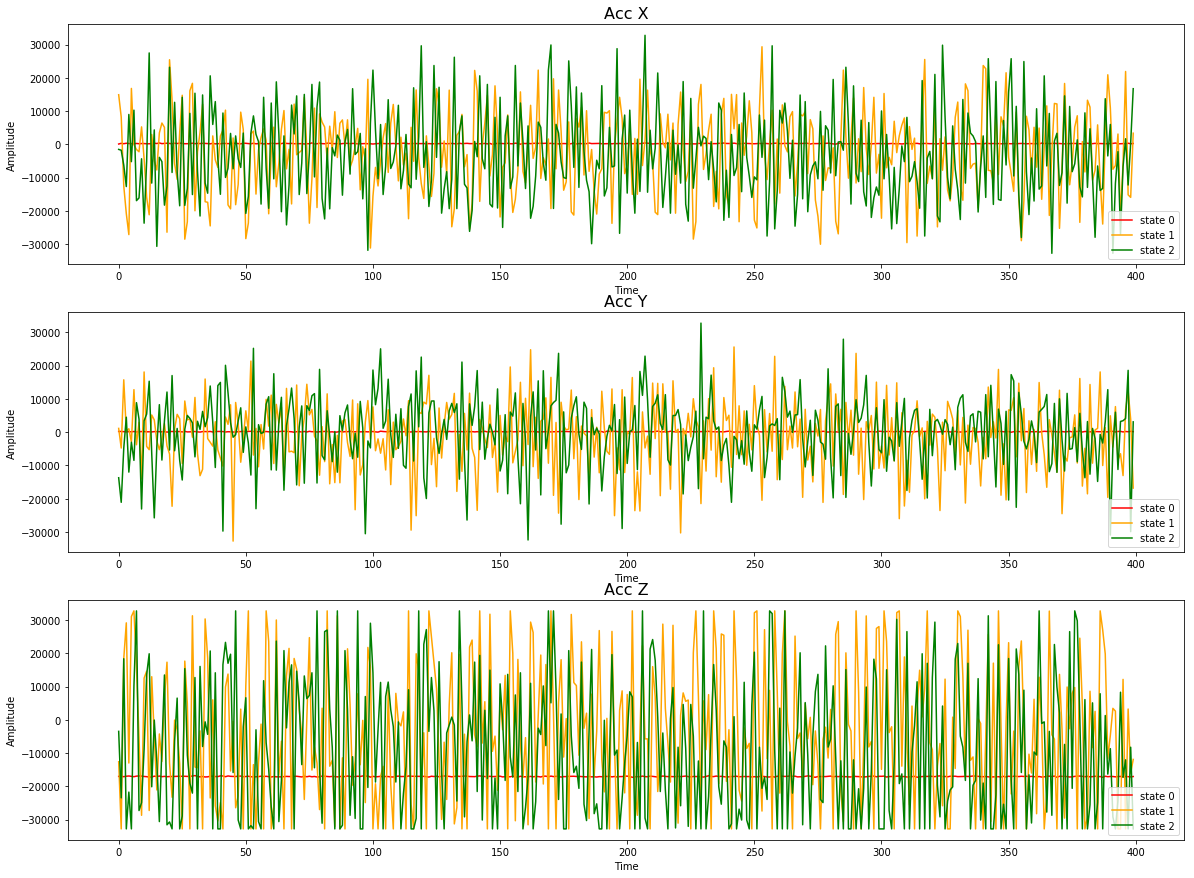

In [121]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20, 15))

signals_to_show = [10, 180, 390]
colors = ["red", "orange", "green"]
labels = ["state 0", "state 1", "state 2"]
titles = ["Acc X", "Acc Y", "Acc Z"]

for c in range(signals.shape[1]):
    for s in range(len(signals_to_show)):
        ax[c].plot(signals[signals_to_show[s],c,:], linestyle='-', color=colors[s], label=labels[s])
    ax[c].legend(loc='lower right')
    ax[c].set_title(titles[c], fontsize=16)
    ax[c].set_xlabel('Time', fontsize=10)
    ax[c].set_ylabel('Amplitude', fontsize=10)
    
plt.show()
        

### Step 3:
Transform the dataset. since the datasets are signals, a [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) is going to be used for the transformation. These transformations are used as Features.

In [46]:
import scipy.signal as signal
from scipy.fftpack import fft

def do_FFTs(values, freq, length, delete_offset=True):
    
    period = 1.0/freq

    _ffts = []
    for n in range(0, values.shape[0]):
        _c = []
        for c in range(0, values.shape[1]):

            v = values[n,c,:]

            if delete_offset:
                v = signal.detrend(v, type == 'constant')

            freq_v = np.linspace(0.0, 1.0 / (2.0 * period), length // 2)
            fft_v_ = fft(v)
            fft_v = 2.0 / length * np.abs(fft_v_[0:length // 2])

            xy_v = np.vstack((freq_v, fft_v)).T
            _c.append(xy_v)
        _ffts.append(_c)      
        
    return np.array(_ffts)


fft_values = do_FFTs(signals, freq, N,)

# dimensions are (n of ffts, n of components, length of ffts, time and amplitude values)
#print("FFTs shape : ",fft_values.shape)

fft_amplitudes = fft_values[:,:,:,1]
print("FFTs amplitudes shape : ",fft_amplitudes.shape)

FFTs amplitudes shape :  (454, 3, 200)


Visualize how the transformations looks like. See if there are differences between classes.

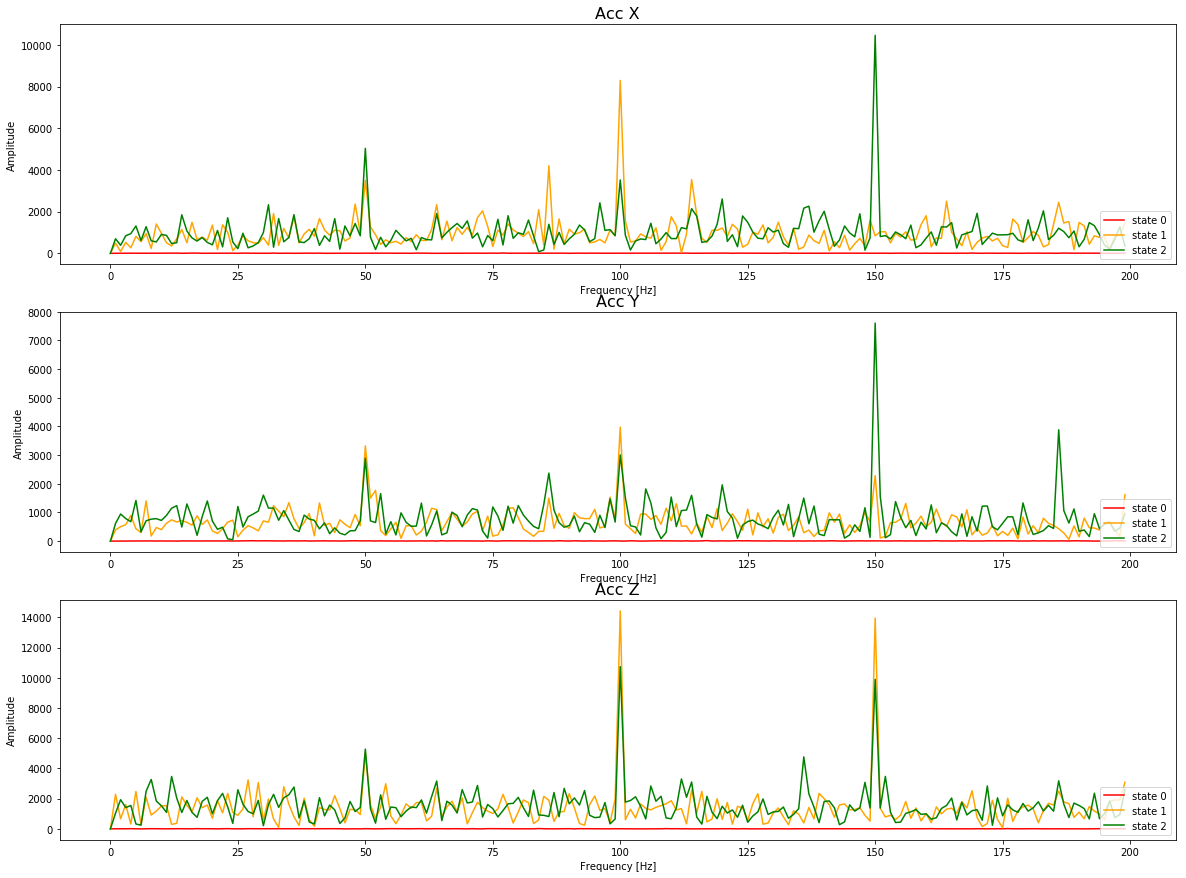

In [122]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20, 15))

signals_to_show = [10, 180, 390]
colors = ["red", "orange", "green"]
labels = ["state 0", "state 1", "state 2"]
titles = ["Acc X", "Acc Y", "Acc Z"]

for c in range(signals.shape[1]):
    for s in range(len(signals_to_show)):
        ax[c].plot(fft_amplitudes[signals_to_show[s],c,:], linestyle='-', color=colors[s], label=labels[s])
    ax[c].legend(loc='lower right')
    ax[c].set_title(titles[c], fontsize=16)
    ax[c].set_xlabel('Frequency [Hz]', fontsize=10)
    ax[c].set_ylabel('Amplitude', fontsize=10)
    
plt.show()

### Step 4:
Train and test split.
Split the Features in a training dataset and a test dataset. Here the split is 40% for testing and 60% for training.

In [90]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(fft_values[:,:,:,1], labels, test_size=0.4, 
                                                    random_state=42, stratify=labels)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

print("train shape: ",x_train.shape)
print("train labels shape: ",y_train.shape)
print("test shape: ",x_test.shape)
print("labels shape: ",y_test.shape)

train shape:  (272, 600)
train labels shape:  (272,)
test shape:  (182, 600)
labels shape:  (182,)


### Step 5:
generate a model

In [93]:
# Import Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Change the label to fit the NN. Converts a class vector (integers) to binary class matrix.
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)


dimensions_in = x_train.shape[1]
dimensions_out = y_train.shape[1]

# Define neuronal network and train.
model = keras.Sequential()
model.add(layers.Dense(100, input_shape=(dimensions_in,), activation='sigmoid'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(100, activation='sigmoid'))
model.add(layers.Dense(dimensions_out, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train, y_train, batch_size=100, epochs=250, 
          validation_data=(x_test, y_test), verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               60100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 70,503
Trainable params: 70,503
Non-trainable params: 0
_________________________________________________________________
None
Train on 272 samples, validate on 182 samples
Epoch 1/250
272/272 [==============================] - 0s 1ms/sample - loss: 1.1514 - acc: 0.3382 - val_loss: 1.1176 - val_acc: 0.3407
Epoch 2/250
272/272 [==============================] - 0s 52us/s

Epoch 53/250
272/272 [==============================] - 0s 54us/sample - loss: 0.4961 - acc: 0.7169 - val_loss: 0.4856 - val_acc: 0.7198
Epoch 54/250
272/272 [==============================] - 0s 59us/sample - loss: 0.4931 - acc: 0.7169 - val_loss: 0.4842 - val_acc: 0.7527
Epoch 55/250
272/272 [==============================] - 0s 49us/sample - loss: 0.4909 - acc: 0.7279 - val_loss: 0.4855 - val_acc: 0.7253
Epoch 56/250
272/272 [==============================] - 0s 58us/sample - loss: 0.4886 - acc: 0.7353 - val_loss: 0.4825 - val_acc: 0.7582
Epoch 57/250
272/272 [==============================] - 0s 52us/sample - loss: 0.4833 - acc: 0.7537 - val_loss: 0.4861 - val_acc: 0.7418
Epoch 58/250
272/272 [==============================] - 0s 53us/sample - loss: 0.4896 - acc: 0.7022 - val_loss: 0.4817 - val_acc: 0.7692
Epoch 59/250
272/272 [==============================] - 0s 53us/sample - loss: 0.4816 - acc: 0.7721 - val_loss: 0.4843 - val_acc: 0.7418
Epoch 60/250
272/272 [===================

Epoch 113/250
272/272 [==============================] - 0s 53us/sample - loss: 0.4711 - acc: 0.7059 - val_loss: 0.4685 - val_acc: 0.6758
Epoch 114/250
272/272 [==============================] - 0s 52us/sample - loss: 0.4689 - acc: 0.7096 - val_loss: 0.4679 - val_acc: 0.6978
Epoch 115/250
272/272 [==============================] - 0s 54us/sample - loss: 0.4691 - acc: 0.7059 - val_loss: 0.4676 - val_acc: 0.7033
Epoch 116/250
272/272 [==============================] - 0s 53us/sample - loss: 0.4677 - acc: 0.7206 - val_loss: 0.4675 - val_acc: 0.6923
Epoch 117/250
272/272 [==============================] - 0s 52us/sample - loss: 0.4698 - acc: 0.7059 - val_loss: 0.4674 - val_acc: 0.6923
Epoch 118/250
272/272 [==============================] - 0s 57us/sample - loss: 0.4625 - acc: 0.7243 - val_loss: 0.4667 - val_acc: 0.7033
Epoch 119/250
272/272 [==============================] - 0s 56us/sample - loss: 0.4707 - acc: 0.6985 - val_loss: 0.4665 - val_acc: 0.7033
Epoch 120/250
272/272 [===========

272/272 [==============================] - 0s 52us/sample - loss: 0.4565 - acc: 0.6875 - val_loss: 0.4509 - val_acc: 0.7363
Epoch 232/250
272/272 [==============================] - 0s 56us/sample - loss: 0.4567 - acc: 0.6985 - val_loss: 0.4509 - val_acc: 0.7253
Epoch 233/250
272/272 [==============================] - 0s 53us/sample - loss: 0.4487 - acc: 0.7243 - val_loss: 0.4510 - val_acc: 0.7253
Epoch 234/250
272/272 [==============================] - 0s 56us/sample - loss: 0.4550 - acc: 0.6691 - val_loss: 0.4514 - val_acc: 0.6978
Epoch 235/250
272/272 [==============================] - 0s 55us/sample - loss: 0.4529 - acc: 0.7243 - val_loss: 0.4513 - val_acc: 0.7033
Epoch 236/250
272/272 [==============================] - 0s 65us/sample - loss: 0.4571 - acc: 0.6985 - val_loss: 0.4530 - val_acc: 0.6978
Epoch 237/250
272/272 [==============================] - 0s 58us/sample - loss: 0.4561 - acc: 0.7022 - val_loss: 0.4515 - val_acc: 0.6923
Epoch 238/250
272/272 [=========================

See how the model performance is.

In [94]:
from sklearn.metrics import classification_report

predictions = model.predict(x_test)    
print(classification_report(y_test.argmax(-1), predictions.argmax(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       0.57      0.83      0.68        60
           2       0.69      0.37      0.48        60

    accuracy                           0.74       182
   macro avg       0.75      0.73      0.72       182
weighted avg       0.75      0.74      0.72       182



Reset model if new training job is desired.

In [89]:
#keras.backend.clear_session()

### Export the Keras model to the Tensorflow Protobuf format

In [57]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

# Note: This directory structure will need to be followed
model_version = '1'
export_dir = 'export/Servo/' + model_version

# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)

# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(inputs={"inputs": model.input}, outputs={"score": model.output})
from tensorflow.keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(sess=sess, tags=[tag_constants.SERVING], 
                                         signature_def_map={"serving_default": signature})
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


### Step 4. Convert TensorFlow model to an Amazon SageMaker-readable format

Move the TensorFlow exported model into a directory export\Servo. Amazon SageMaker will recognize this as a loadable TensorFlow model. Your directory and file structure should look like this:

In [125]:
!ls export

Servo


In [126]:
!ls export/Servo

1


In [127]:
!ls export/Servo/1/variables

variables.data-00000-of-00001  variables.index


Tar the entire directory and upload to Amazon S3

In [128]:
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

role = sagemaker.get_execution_role()

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Step 5. Deploy the trained model

The entry_point file train.py can be an empty Python file.

In [74]:
!touch train.py

In [75]:
from sagemaker.tensorflow.model import TensorFlowModel

sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

2.1.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [76]:
%%time

import time

endpoint_name = "ssv-sagemaker-"+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print(endpoint_name)

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium",
                                  endpoint_name= endpoint_name)

ssv-sagemaker-2020-03-23-12-48-01
-----------!CPU times: user 537 ms, sys: 42.7 ms, total: 580 ms
Wall time: 5min 31s


In [77]:
from sagemaker.tensorflow.model import TensorFlowModel

predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

### Test the model

Step 6. Invoke the endpoint

Invoke the Amazon SageMaker endpoint from the notebook

In [123]:
data = np.random.randn(1,600)
r = predictor.predict(data)

output_list = r["outputs"]["score"]["float_val"]
y = np.array(output_list).argmax(axis=-1)

print(y)

0


Invoke the Amazon SageMaker endpoint using a boto3 client

In [98]:
data = np.random.randn(1,600)
data = data.tolist() 

endpoint_name = "ssv-sagemaker-2020-03-23-12-48-01"

client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(EndpointName=endpoint_name, Body=json.dumps(data))
response_body = response['Body']
bstr = response_body.read().decode("utf-8") 
    
dbstr = eval(bstr)
output_list = dbstr["outputs"]["score"]["floatVal"]
    
print(y_classes)

1


### Delete the endpoint

In [ ]:
#predictor.delete_endpoint()